In [1]:
import tensorflow as tf
import numpy as np
import twodlearn.feedforward as tdlf
from twodlearn import common
from twodlearn.bayesnet import *
from twodlearn import monitoring
from twodlearn.datasets.generic import Datasets
from twodlearn.optim import OptimizationManager
import twodlearn.tests.bayesnet_test as test
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_dataset_heteroscedastic = True
is_model_heteroscedastic = True

### 1. Create Dataset

In [3]:
if is_dataset_heteroscedastic:
    dataset = test.create_heteroscedastic_dataset(n_samples=1000)
else:
    dataset = test.create_homoscedastic_dataset(n_samples=1000)

Data set created, shape:  (1000,)


### 2. Define Model

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [5]:
n_inputs= 1
n_hidden = [10]
n_outputs= 1 

inputs = tf.placeholder(tf.float32)
with common.reuse_scope():
    #gaussian = BayesianMlp(n_inputs, n_outputs, n_hidden).evaluate(inputs)
    #bernoulli = BernoulliBayesianMlp(n_inputs, n_outputs, n_hidden)(inputs)
    if is_model_heteroscedastic:
        p_y_model = HeteroscedasticNormalMlp({'n_inputs':n_inputs,
                                                'n_outputs':n_outputs,
                                                'n_hidden':n_hidden,
                                                'afunction':tdlf.selu01},
                                               {'n_inputs':n_inputs,
                                                'n_outputs':n_outputs,
                                                'n_hidden':[20],
                                                'afunction':tdlf.selu01,
                                                'lower':0.05,
                                                'upper':None}
                                               )
        p_y = p_y_model(inputs)
        with tf.name_scope('loss'):
            fit_loss = GaussianNegLogLikelihood(p_y)
            reg_loc = GaussianKL(p_y.loc.weights,
                                 tf.distributions.Normal(loc=0.0,
                                                         scale=1000.0))
            reg_scale = GaussianKL(p_y.scale.weights,
                                   tf.distributions.Normal(loc=0.0,
                                                           scale=100.0))
            reg_loss = reg_loc.value + reg_scale.value
        
    else:
        p_y_model = ConditionalNormalMlp({'n_inputs':n_inputs,
                                        'n_outputs':n_outputs,
                                        'n_hidden':n_hidden,
                                        'afunction':tdlf.selu01},
                                        LocClass=BayesianMlp)
        p_y = p_y_model(inputs)
        fit_loss = GaussianNegLogLikelihood(p_y)
        reg_loss = GaussianKL(p_y.loc.weights,
                              tf.distributions.Normal(loc=0.0,
                                                 scale=1000.0)).value
    loss = fit_loss.value + (1.0/dataset.train.n_samples)*reg_loss


py_test = p_y_model.mc_evaluate(n_particles=1000, name='mc_test')

In [6]:
# ---------- ignore ------- #
monitor = monitoring.TrainingMonitorManager(
    log_folder='tmp/',
    tf_graph=sess.graph)


In [7]:
optimizer = tf.train.AdamOptimizer(0.02).minimize(loss)
    
monitor = monitoring.TrainingMonitorManager(
    log_folder='tmp/',
    tf_graph=sess.graph)

monitor.train.add_monitor(monitoring.OpMonitor(loss,
                                               name="train/loss"))
#monitor.train.add_monitor(monitoring.OpMonitor(tf.reduce_mean(p_y.scale),
#                                               name="train/mean_y_scale"))

#monitor.train.add_monitor(monitoring.OpMonitor(tf.reduce_max(p_y.y),
#                                               name="train/max_y"))
#monitor.train.add_monitor(monitoring.OpMonitor(tf.reduce_max(p_y.loc.layers[0].z_distribution.scale),
#                                               name="train/max_y_layer0"))
#monitor.train.add_monitor(monitoring.OpMonitor(tf.reduce_max(p_y.loc.layers[1].y_distribution.scale),
#                                               name="train/max_y_layer1"))

monitor.train.add_monitor(monitoring.OpMonitor(tf.reduce_max(reg_scale.p.scale),
                                               name="weights/max_scale"))
#monitor.train.add_monitor(monitoring.OpMonitor(tf.reduce_min(reg_loss.p.scale),
#                                               name="weights/min_scale"))

optimizer = OptimizationManager(session=sess,
                                step_op=optimizer,
                                monitor_manager=monitor,
                                n_logging=100)

### 3. Train

In [8]:
def feed_train():
    feed_dict={p_y.inputs: np.expand_dims(dataset.train.x, 1),
           fit_loss.labels: np.expand_dims(dataset.train.y, 1)}
    return feed_dict

In [9]:
tf.global_variables_initializer().run()

In [10]:
optimizer.run(n_train_steps=5000,
              feed_train=feed_train)

100 | [('train/loss', -0.044696199595928215), ('weights/max_scale', 0.28260925993323327)] | []
200 | [('train/loss', -0.8039788722991943), ('weights/max_scale', 0.5916537255048752)] | []
300 | [('train/loss', -0.9439771223068237), ('weights/max_scale', 0.894764874577522)] | []
400 | [('train/loss', -0.9536813414096832), ('weights/max_scale', 1.1207537007331854)] | []
500 | [('train/loss', -0.9863668406009674), ('weights/max_scale', 1.1442107474803922)] | []
600 | [('train/loss', -1.002307748198508), ('weights/max_scale', 0.9127936607599257)] | []
700 | [('train/loss', -0.9827292743325222), ('weights/max_scale', 0.873555632829666)] | []
800 | [('train/loss', -1.0429400357604022), ('weights/max_scale', 0.8886937683820723)] | []
900 | [('train/loss', -0.9344572758674619), ('weights/max_scale', 0.742170916199684)] | []
1000 | [('train/loss', -1.0571228751540187), ('weights/max_scale', 0.8913551974296569)] | []
1100 | [('train/loss', -1.0808320641517637), ('weights/max_scale', 1.17873687505

In [11]:
assert np.isfinite(optimizer.monitor_manager.train['train/loss'].current_value),\
       'training resulted in nan for bayesnet'

### 4. Evaluate

In [15]:
test_x = np.linspace((1+0.5)*dataset.train.x.min(), 
                     (1+0.1)*dataset.train.x.max(),
                     num=1000)
test_x = np.expand_dims(test_x, axis=1)

y_mean = list() 
y_std = list()
for i in range(test_x.shape[0]):
    m_i, std_i = sess.run([py_test.samples.mean, py_test.samples.stddev],
                          feed_dict={py_test.inputs.base:np.expand_dims(test_x[i], axis=1)})
    #m_i, std_i = sess.run([py_test.y_distribution.loc, py_test.y_distribution.scale],
    #                      feed_dict={py_test.inputs:np.expand_dims(test_x[i], axis=1)})
    #m_i = np.mean(m_i, 0)
    #std_i = np.mean(std_i, 0)
    
    y_mean.append(m_i)
    y_std.append(std_i)
    
y_mean = np.concatenate(y_mean, 0)
y_std = np.concatenate(y_std, 0)

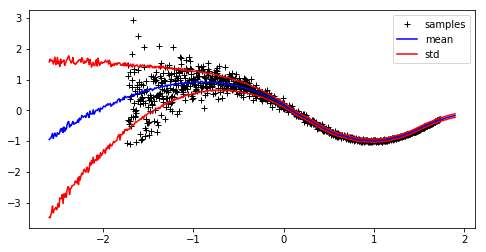

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
test.plot_yp(test_x, y_mean, y_std, ax, dataset.train)

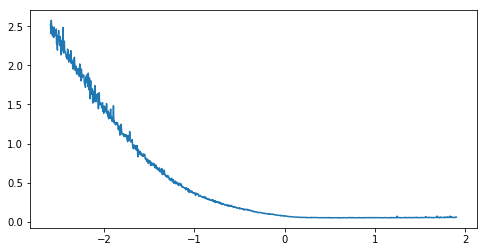

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(test_x, y_std)